#How to view this Project?

*   The Project has been prepared in a document-wise sequential format. So running code cells isnt really a necessity. 

*   If you want to run the corresponding Code Cells (At times, some Visualizations might not render immediately, hence re-running the code Cells becomes essential), hover around each and every 'Show Code' option, click on the 'Play Button' circle that appears. Please run each Code Cell sequentially one after the other from the begining, even if you need to run only one particular code cell, to avoid errors/crashes.






Final Note: The research in this project is solely based on the TMDB Movie Database present on Kaggle. Heres a reminder to not to take this project as an exact represntation of the Real world Scenario. 

In [2]:
#@title Code for loading the dataset in Pandas/ creating checkpoints / storing Movie plots separately in a data structure for future analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

data=pd.read_csv(r'https://raw.githubusercontent.com/ayanatherate/Movie_Plot_Visualization_And_Analysis/main/Movies.csv',encoding='utf-8',low_memory=False)
data.head()

datacopy=data.copy()
datacopy2=data.copy()
#creating a checkpoint

saved_overview_text=[i for i in data['overview']]

In [ ]:
#@title  Code for initial processing\ Downloading required API for decoding language Codes \ Visualizing number of samples from each Language category present


!pip install langcodes

!pip install language_data


lang_codes=data['original_language'].unique()

from langcodes import *


def map_code2lang(x):
    for i in lang_codes:
        if i==x:
            language=Language.make(language=i).display_name()
        
    return language.lower()

data['original_language']=data['original_language'].apply(lambda x: map_code2lang(x))

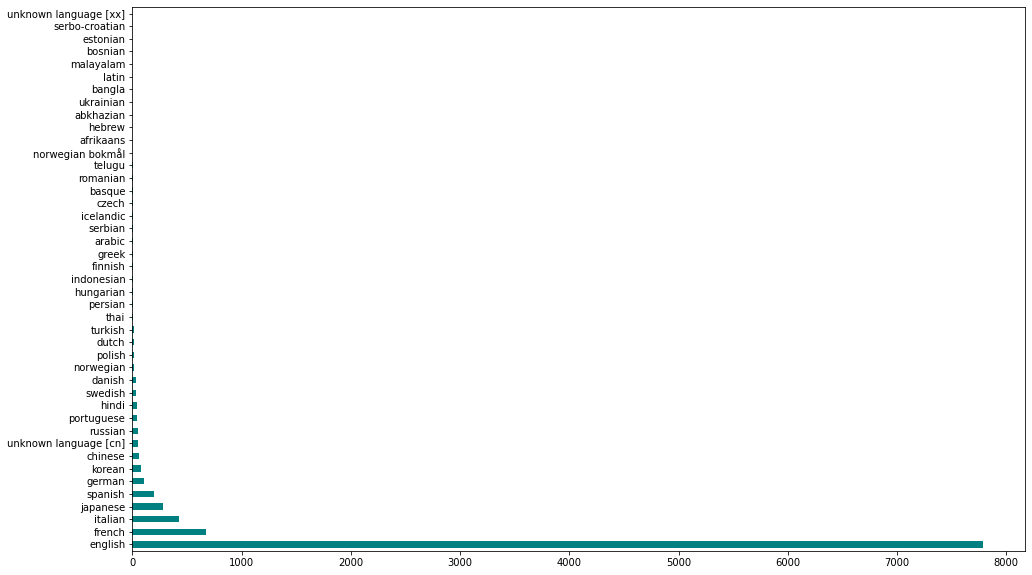

In [4]:
#@title Number of Movie Samples present from each Language Category in the Dataset
data['original_language'].value_counts().plot(kind='barh',figsize=(16,10),color='teal');


#### So, the first problem here entials the huge class imbalance that lies in the dataset. To tackle that, I am basing our judgements on the 'top 50' (in terms of 'vote_score') from the highest crossing languages in the dataset (like english, french,hindi, italian etc) which have round >100 movies each. Although common middle-eastern languages like persian and arabic each have only 7 and 3 (respectively) representatives in the dataset, I am clubbing them together to have some significant reprentation from the middle-east film world. Others with <30 representations in the dataset, will unfortunately have to be skipped to remove bias.

In [5]:
#@title Categorizing the release years of movies into different timeframe periods. For the study, divided the timeframe of various movies into 4 separate timeframes. Took refernce from this blog here which discusses the major timelines of world cinema: https://timelineofcinema.com/
data['release_date']=pd.to_datetime(data['release_date'],format='%Y-%m-%d')

stored_year_labels=[]
for i in pd.DatetimeIndex(data['release_date']).year:
    stored_year_labels.append(i)
print(f"Timeframe start: {min(stored_year_labels)}")
print(f"Timeframe end: {max(stored_year_labels)}")

print(f"Timeframe length: {max(stored_year_labels)-min(stored_year_labels)}")

timeframe_categories=[]


for j in stored_year_labels:
        if 1902<=j<1945:
            timeframe_categories.append('1902-1945')
        elif 1945<=j<1985:
            timeframe_categories.append('1945-1985')
        elif 1985<=j<2000:
            timeframe_categories.append('1985-2000')
        elif 2000<=j<=2010:
            timeframe_categories.append('2000-2010')
        elif 2010<j<=2022:
            timeframe_categories.append('2010-2022')
        
            
data['timeframes']=timeframe_categories

Timeframe start: 1902
Timeframe end: 2022
Timeframe length: 120


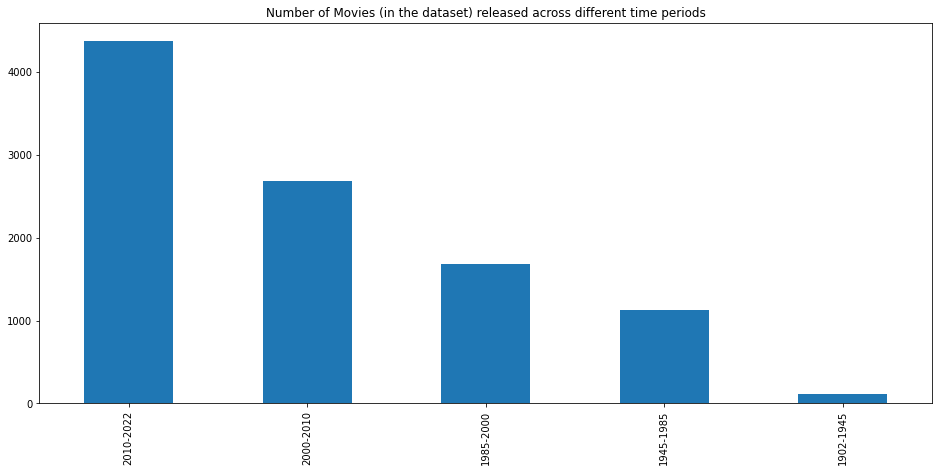

In [6]:
#@title Number of movies across each timeframe after initial transformation
data['timeframes'].value_counts().plot(kind='bar',figsize=(16,7),title='Number of Movies (in the dataset) released across different time periods');

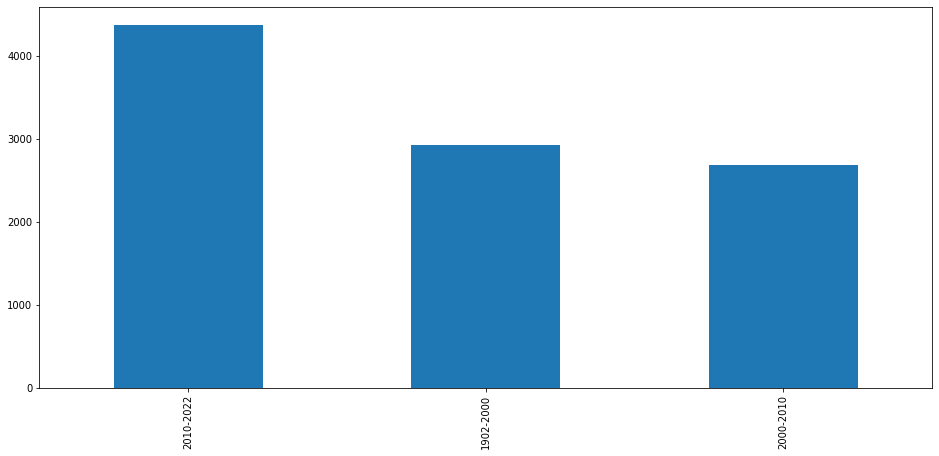

In [7]:
#@title Seems like we haven't fought off the huge Class Imbalance just enough, yet! Especially for the last 3 time periods, observations present in the dataset are quite low! Hence, the second attempt was to club the last 3 time periods together. So the final timeframes are: 1) 2010-2022 2) 2000-2010 3) 1902-2000
def club_timeframes_together(x):
    if x=='1902-1945':
        return '1902-2000'
    elif x=='1945-1985':
        return '1902-2000'
    elif x=='1985-2000':
        return '1902-2000'
    elif x=='2000-2010':
        return '2000-2010'
    elif x=='2010-2022':
        return '2010-2022'
    
data['timeframes']=data['timeframes'].apply(lambda x: club_timeframes_together(x))

data['timeframes'].value_counts().plot(kind='bar', figsize=(16,7));

In [8]:
#@title Removing null observations and re-storing in a data structure
data['overview'].isna().sum()
data.dropna(inplace=True,axis=0,subset=['overview','timeframes'])
text_overview=[[i] for i in data['overview']]
#text_overview

In [ ]:
#@title Installing NLTK requirements, preprocessing text (Cleaning/Stemming/Lemmatization) and storing the same in a Data Structure for further analysis.
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
words_remove=['The','the','but','But','When','when','after']
for i in words_remove:
    stop.add(i)
def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for i in range(len(text_overview)):
        for news in text_overview[i]:
            words=[w for w in word_tokenize(news) if (w not in stop)]
        
            words=[lem.lemmatize(w) for w in words if len(w)>2]
        
            corpus.append(words)
    return corpus

corpus=preprocess_news(text_overview)
data['corpus']=corpus
data['corpus2']=corpus

def strip_corpus(x):
    import re
    x=re.sub('[^a-zA-Z0-9 ]','',str(x))
    return x

data['corpus']=data['corpus'].apply(lambda x: strip_corpus(x))

In [10]:
#@title Singling out each chosen movie language category and storing the same in separate data structures for future analysis
data.sort_values(ascending=False,by='popularity',ignore_index=True,inplace=True)
#data

str_hi=' '
for i in data[data['original_language']=='hindi']['corpus'][:50]:
    str_hi+=i+' '

str_en=' '
en_top50=data[data['original_language']=='english'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in en_top50['corpus']:
    str_en+=i+' '

str_es=' '
es_top50=data[data['original_language']=='spanish'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in es_top50['corpus']:
    str_es+=i+' '

str_fr=' '
fr_top50=data[data['original_language']=='french'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in fr_top50['corpus']:
    str_fr+=i+' '

str_it=' '
it_top50=data[data['original_language']=='italian'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in it_top50['corpus']:
    str_it+=i+' '

str_ja=' '
for i in data[data['original_language']=='japanese']['corpus']:
    str_ja+=i+' '

str_ru=' '
for i in data[data['original_language']=='russian']['corpus']:
    str_ru+=i+' '

str_ko=' '
ko_top50=data[data['original_language']=='korean'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in ko_top50['corpus']:
    str_ko+=i+' '

str_pe=' '
for i in data[data['original_language']=='persian']['corpus']:
    str_pe+=i+' '
    
str_ar=' '
for i in data[data['original_language']=='arabic']['corpus']:
    str_ar+=i+' '

str_middleeast=str_pe+str_ar


stored_movie_alllang=[str_hi,str_en,str_es,str_fr,str_it,str_ko,str_ja,str_ru,str_middleeast]



In [ ]:
#@title Initializing Sentence Transformers, Choosing required BERT encodings model for encoding text
!pip install sentence_transformers

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-distilroberta-v1')

emb_hi=model.encode(str_hi)
emb_en=model.encode(str_en)
emb_es=model.encode(str_es)
emb_fr=model.encode(str_fr)
emb_it=model.encode(str_it)
emb_ko=model.encode(str_ko)
emb_ja=model.encode(str_ja)
emb_ru=model.encode(str_ru)
emb_me=model.encode(str_middleeast)




embeddings=[emb_hi,emb_en,emb_es,emb_fr,emb_it,emb_ko,emb_ja,emb_ru,emb_me]



---



---



# Given each language (Country), is there a similarity in the Content (as understood from Movie Decsriptions) of each language's (Country's) top movies with the others?

### Here, I'm trying to find the answer with the help of a Cosine Similarity comparison between an accumulation of movie descriptions of each language wrt the other. The final result is presented in the form of a Heatmap Matrix. 
Numbers for each language are in range (0,1) where higher the assigned score, higher is the similarity between a language's movies with respect to the Other.



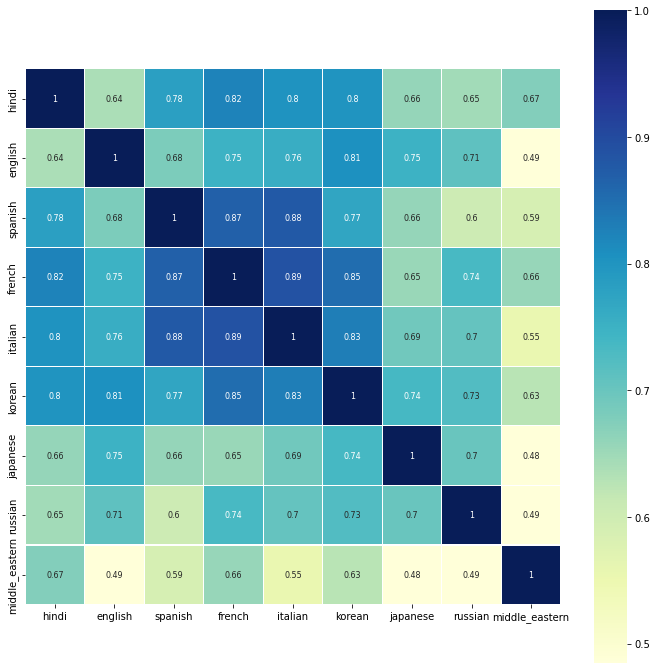

<Figure size 432x288 with 0 Axes>

In [12]:
#@title Code for generating the similarity matrix, plotting the same using matplotlib
from sklearn.metrics.pairwise import cosine_similarity as cs
scores=[]
for i in range(len(embeddings)):
    for j in range(len(embeddings)):
        s=cs([embeddings[i]],[embeddings[j]])
        scores.append(s)

len_arr=len(scores)
reshape_x=-int(np.sqrt(len_arr))
reshape_y= int(np.sqrt(len_arr))

scores_arr=np.array(scores).reshape(reshape_x,reshape_y)

ylab=['hindi','english','spanish','french','italian','korean','japanese','russian','middle_eastern']
xlab=ylab

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(scores_arr, xticklabels=xlab,yticklabels=ylab,square=True, cmap="YlGnBu", linewidths=0.1,annot=True, annot_kws={"fontsize":8})
plt.show()
plt.savefig('similarity.png')


## So what can we understand from this Matrix?

For one, darker cells represent, a higher similarity and consequently, a lighter cell means a lower similarity. So what are some key
understandings from the same?

1) Hindi has a very high similarity with French, Italian & Korean Movies. 
   This can be due to the fact that some the of 'popular' films in these 
   languages have revolved around Love and Romance.

2) High Similarity of French Movies with Spanish and Italian. This isn't too surprising since both these European countries are neighbors to France.

3) Korean Movies seem to have a higher similarity with French and Italian Movies as compared to its neighbour Japan. Possibly, a huge number of Popular 'movies' from Japan are Animes, so that kinda explains the reason.

4) Although, there weren't too many representative samples from the Middle East,
the highest similarity of Middle Eastern films are with Hindi and Korean. Possibly, Asian movie plots revolve around the similar stories. 

5) Japanese movies have the highest similarity with English Movies. This isn't also too surprising as the majority of popular Japanese movies being Animes, can have an explainable similarity with English, for which also, some popular Movie plots revolve around Fiction.



---



---



#On an average, which Country's popular films showed the most deviant plots as compared to others?

We can find this answer by finding by the mean similarity score of a particular Movie language with the Other and choosing the one with the most Standard Deviation. Here, since the number of samples being less, we can do that just by 
selecting the language with the lowest mean score.

In [13]:
#@title Code for finding the Same.

mean_similarity_arr=[]
for i in range(len(scores_arr)):
    list(scores_arr[i]).remove(max(scores_arr[i]))
    mean_similarity=np.mean(scores_arr[i])
    mean_similarity_arr.append(mean_similarity)

movies_in_list=['Hindi','English','Spanish','French','Italian','Korean','Japanese','Russian','Middle Eastern']
len_plots=[len(str_hi),len(str_en),len(str_es),len(str_fr),len(str_it),len(str_ko),len(str_ja), len(str_ru), len(str_middleeast)]


i=0
se_store_arr=[]
while i<len(mean_similarity_arr):
  se=np.std(scores_arr[i])/np.sqrt(len_plots[i])
  se=round(se,3)
  se_store_arr.append(se)

  print(f'Mean Similarity of {movies_in_list[i]} is {mean_similarity_arr[i]} with a Standard Error of +-{se_store_arr[i]}')
  i+=1




Mean Similarity of Hindi is 0.7586308717727661 with a Standard Error of +-0.001
Mean Similarity of English is 0.7310898900032043 with a Standard Error of +-0.001
Mean Similarity of Spanish is 0.7590789198875427 with a Standard Error of +-0.001
Mean Similarity of French is 0.8031951785087585 with a Standard Error of +-0.001
Mean Similarity of Italian is 0.7898948192596436 with a Standard Error of +-0.001
Mean Similarity of Korean is 0.7943196296691895 with a Standard Error of +-0.001
Mean Similarity of Japanese is 0.7039727568626404 with a Standard Error of +-0.0
Mean Similarity of Russian is 0.7016045451164246 with a Standard Error of +-0.001
Mean Similarity of Middle Eastern is 0.6175105571746826 with a Standard Error of +-0.004


Based on the above outputs, we can infer that most similarity scores revolved around ~0.75, Middle Eastern films showed the most deviant statistic with a score of 0.61. We can say that Popular films from this region had the most 'deviant' or different plots as compared to the Other film languages. If we check the WordCloud of Middle Eastern films, majority of the films in the sample were based on War.



---



---




#Which were the most 'Outlier' Movies in the sample/ Which Movies had a 'different' plot as compared to the others?

We can answer this if we can plot the Movie Plots in 2D and check out by manual observation, which Movies were an 'Outlier' from the entire group. Hence, PCA to the rescue!

In [14]:
#@title Code for PCA/ Plotting using Plotly
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer()
docs = tfidf.fit_transform(data['corpus'])

from sklearn.decomposition import PCA
pca=PCA(2)
x_pca=pca.fit_transform(docs.toarray())

import plotly.express as px
fig = px.scatter(x_pca, x=x_pca[:,0], y=x_pca[:,1],color=data['timeframes'],
                 hover_name=data['title'],title='Visualization of top movies across the world, across different timeframes. Hover on a particular dot (bubble) to reveal Movie Name',log_x=False, size_max=100)
fig.show()



So what do we understand from this plot?

First of all, a movie description doesn't really provide a true understanding of how the movie is. We (and in this case, the machine) can only have a very high level understanding of what truly is the content of a movie from the (usually) 1/2 liner Descriptions.

Thus, one shouldn't read too much into this plot (or on any other statistic established.

Keeping that in mind, if we observe towards right and right upper side, certain 
points appear quite disintegrated from the rest of the points (movies) in the mesh. Then again, establishing any point openly as an 'Outlier' is a much calculated/debated task in Data Science. On an averge, thus we can consider these points to be potential 'Outliers'/ movies with the most different plots as compared to the others.


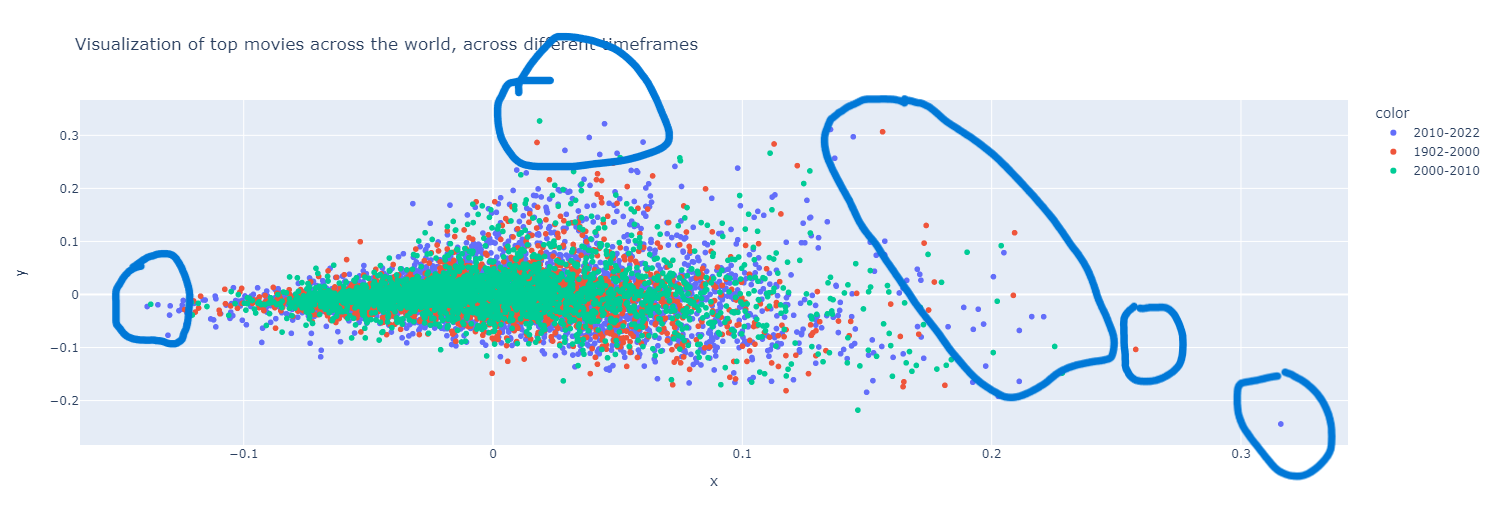

In [22]:
#@title Some of the Movies which have possible 'Outlier'/'different' plots, as visible from the PCA.
outlier_movie_descs=['Just One of the Guys','The Age of Innocence','Playing It Cool','The Last Kiss','Boys Cry','The Hunt','Detention','Rab Ne Bana Di Jodi','Brittany Runs a Marathon','Skylines']

for movie in outlier_movie_descs:

  print(f"{movie} - {data[data['title']==movie]['overview'].values[0]}")
  print()
  print()


Just One of the Guys - When Terry Griffith loses her high school's writing competition, she's convinced that it's because she's a girl. So Terry decides to change high schools and pose as a boy to prove her point. Her brother, Buddy, helps her pass as a guy so well that she is soon making friends with the boys at school, including the attractive Rick, who becomes her new best friend. But her gender-swapping makes things difficult when she falls in love with him.


The Age of Innocence - Tale of 19th century New York high society in which a young lawyer falls in love with a woman separated from her husband, while he is engaged to the woman's cousin.


Playing It Cool - A young man meets and instantly falls in love with an engaged woman.


The Last Kiss - Michael has a great job, has his 4 best friends, and is in love with a beautiful girl at 30. He loves Jenna but his life seems predictable until someone else enters his life. It seems that everybody's having relationship problems.


Boy

So, are these really 'Outlier'-worthy movies with respect to their plot (descriptions?). Well, atleast thats what Linear Statistics tells us!

Also, another thing that's really apparent from this plot is that Movies across different timeframes can't really be clustered on the basis of the Stories. That is, there isnt any timeframe in which Movies released showed a slightly 'different' Story structure, atleast which can be seen from the Movies present in this sample.

#Across different timeframes, how has the average rating of Movies changed? 

In [48]:
#@title As we can see, average rating doesn't really vary much. So, it's safe to say that there hasn't been any particular timeframe, on which Movies released received the most positive Audience Feedback!
data.groupby(['timeframes'])['vote_average'].mean()

timeframes
1902-2000    6.884252
2000-2010    6.493615
2010-2022    6.562174
Name: vote_average, dtype: float64